<a href="https://colab.research.google.com/github/OlyKoek/MyStudy-AI-app/blob/feature-update-ml/create_multimodal_embeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチモーダルなエンベディングモデルの作成
# Mini-CLIP: Text + Image shared embedding

- Text: multilingual MiniLM (TinyBERT)
- Image: MobileNetV3-Small
- Projection Head: 256 dimention shared space
- Loss: CLIP-style contrastive loss
- VectorStore: SimpleVetorDB    

# Import and Config

In [3]:
!pip install torch torchvision torchaudio --quiet
!pip install transformers umap-learn matplotlib pandas scikit-learn plotly --quiet

!pip install kaggle

import os
import json
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModel

import torchvision.models as models
import torchvision.transforms as T

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
import requests
from IPython.display import display

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# モデルと次元数
TEXT_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
EMBED_DIM = 256

DEVICE: cpu


In [4]:
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('username')
os.environ["KAGGLE_KEY"] = userdata.get('token')

!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           3595         63  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           9467        235  1.0              
prince7489/employee-salary-dataset                              Employee Salary Dataset                                   1121  2025-11-16 14:32:04.360000            930         24  0.9411765        


# Utils

In [14]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """
    ベクトル a, b のコサイン類似度を返すための関数
    """
    a_flat = a.flatten()
    b_flat = b.flatten()
    denom = (np.linalg.norm(a_flat) * np.linalg.norm(b_flat) + 1e-8)
    return float(np.dot(a_flat, b_flat) / denom)


def load_image(x):
    """
    Imageを読み込むための関数
    入力 x:
      - str(URL or file path)
      - PIL.Image.Image
    """
    if isinstance(x, Image.Image):
        return x.convert("RGB")

    if isinstance(x, str):
        if x.startswith("https://") or x.startswith("http://"):
            response = requests.get(x)
            img = Image.open(BytesIO(response.content))
            return img.convert("RGB")
        else:
            img = Image.open(x)
            return img.convert("RGB")

    raise ValueError(f"Unsupported image input type: {type(x)}")


def plot_umap_matplotlib(embs, labels, texts=None, title="UMAP"):
    """
    MatplotlibでUMAPを描画
    embs: (N, D) numpy array
    labels: list[str] same length as N
    texts:  list[str] hover表示用（任意）
    """
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine")
    coords = reducer.fit_transform(embs)

    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(labels):
        plt.scatter(coords[i, 0], coords[i, 1])
        if texts is not None:
            plt.text(coords[i, 0], coords[i, 1], texts[i][:10], fontsize=8)
    plt.title(title)
    plt.show()


def plot_umap_plotly(embs, labels, texts=None, extra_meta=None, title="UMAP (Interactive)"):
    """
    PlotlyでインタラクティブなUMAPを描画
    """
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine")
    coords = reducer.fit_transform(embs)

    data = {
        "x": coords[:, 0],
        "y": coords[:, 1],
        "type": labels,
    }
    if texts is not None:
        data["text"] = texts
    if extra_meta is not None:
        for k, v in extra_meta.items():
            data[k] = v

    df = pd.DataFrame(data)
    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="type",
        hover_data=list(data.keys()),
        title=title,
        width=800,
        height=600,
    )
    fig.show()


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


## Core Classes
- TextEncoder
- ImageEncoder
- MiniCLIP
- SimpleVectorDB

In [6]:
class TextEncoder(nn.Module):
    """
    TinyBERT系でテキストをエンコードするクラス
    Linear Projectionで256次元に射影変換
    """
    def __init__(self, model_name: str, out_dim: int = EMBED_DIM, device: torch.device = DEVICE):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        hidden = self.model.config.hidden_size
        self.projector  = nn.Linear(hidden, out_dim).to(device)

    def forward(self, inputs):
        """
        HuggingFaceスタイルのForward関数を参考に実装
        B: バッチサイズ
        3: チャネル数(RGB)
        H, W: 画像の高さと幅
        T: トークン数
        H: モデルの隠れ層次元数
        out_dim: 射影後の次元数
        """
        outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # (B, T, H) -> (B, H)
        projected = self.projector(embeddings)  # (B, out_dim)
        return projected

    def encode(self, texts, normalize: bool = True) -> torch.Tensor:
        """
        textsをエンコードしてベクトルを返す関数

        texts: list[str]
        normalize: bool - 出力ベクトルを正規化するかどうか
        """
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            emb = outputs.last_hidden_state.mean(dim=1)  # (B, H)

        proj = self.projector(emb)  # (B, out_dim)

        if normalize:
            proj = proj / (proj.norm(dim=1, keepdim=True) + 1e-8)

        return proj

In [7]:
class ImageEncoder(nn.Module):
    """
    MobileNetV3-Smallで画像をエンコードするクラス
    Linear Projectionで256次元に射影変換
    """
    def __init__(self, out_dim: int = EMBED_DIM, device: torch.device = DEVICE):
        super().__init__()
        self.device = device
        self.model = models.mobilenet_v3_small(pretrained=True)
        self.model.eval()
        self.features = self.model.features.to(device)
        self.projector = nn.Linear(576, out_dim).to(device)  # MobileNetV3-Smallの最終特徴量次元数は576

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])

    def encode(self, images, normalize: bool = True) -> torch.Tensor:
        """
        画像リストをエンコードしてベクトルを返す関数

        images: list[PIL.Image.Image] または 単一のPIL.Image.Image
        normalize: bool - 出力ベクトルを正規化するかどうか
        """
        single = False
        if not isinstance(images, (list, tuple)):
            images = [images]
            single = True

        tensors = []
        for img in images:
            pil_img = load_image(img)
            tensor = self.transform(pil_img) # (3, H, W)
            tensors.append(tensor)
        batch = torch.stack(tensors, dim=0).to(self.device)  # (B, 3, H, W)

        with torch.no_grad():
            feat = self.features(batch)  # (B, 576, 7, 7)
            feat = feat.mean(dim=[2, 3])  # (B, 576)

        proj = self.projector(feat)  # (B, out_dim)

        if normalize:
            proj = proj / (proj.norm(dim=1, keepdim=True) + 1e-8)

        if single:
            return proj # (1, out_dim)
        return proj  # (B, out_dim)

In [8]:
class MiniCLIP:
    """
    TextEncoder と ImageEncoder を共有 256次元空間に揃え、
    CLIP風の対照学習で projector 層のみを学習するクラス。
    """
    def __init__(self, text_encoder: TextEncoder, image_encoder: ImageEncoder, temperature: float = 0.07):
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature

        params = list(self.text_encoder.projector.parameters()) + \
                 list(self.image_encoder.projector.parameters())
        self.optimizer = AdamW(params, lr=1e-4)


    def compute_loss(self, img_vecs: torch.Tensor, txt_vecs: torch.Tensor) -> torch.Tensor:
        """
        CLIP風の対照学習の損失を計算する関数
        img_vecs: (B, D)
        txt_vecs: (B, D)
        """
        # 類似度行列[B, B]を計算
        sim_matrix = torch.matmul(img_vecs, txt_vecs.T)
        sim_matrix = sim_matrix / self.temperature

        labels = torch.arange(len(img_vecs), device=sim_matrix.device)

        loss_img2txt = F.cross_entropy(sim_matrix, labels)
        loss_txt2img = F.cross_entropy(sim_matrix.T, labels)

        loss = (loss_img2txt + loss_txt2img) / 2.0
        return loss


    def train(self, pairs, epochs: int = 10, batch_size: int = 32):
        """
        学習を実行する関数
        pairs: list of (PIL.Image.Image, str)
        """

        for epoch in range(epochs):
            self.optimizer.zero_grad()

            texts  = [p["text"]  for p in pairs]
            images = [p["image"] for p in pairs]

            txt_vecs = self.text_encoder.encode(texts, normalize=True)  # (B, D)
            img_vecs = self.image_encoder.encode(images, normalize=True)  # (B, D)

            loss = self.compute_loss(img_vecs, txt_vecs)
            loss.backward()
            self.optimizer.step()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        print("Training completed.")

In [9]:
class SimpleVectorDB:
    """
    非常にシンプルなベクトルストア。
    - items: List[{"vec": np.ndarray, "type": ..., "text": ..., "image": ...}]
    """
    def __init__(self):
        self.items = []

    def add(self, vec: np.ndarray, metadata: dict):
        self.items.append({
            "vec": vec.astype("float32"),
            **metadata
        })

    def build_from_pairs(self, text_encoder: TextEncoder, image_encoder: ImageEncoder, pairs):
        """
        pairs: List[{"image": ..., "text": ...}]
        """
        self.items = []
        for p in pairs:
            # text embedding
            t_vec = text_encoder.encode(p["text"]).cpu().detach().numpy()[0]
            self.add(t_vec, {
                "type": "text",
                "text": p["text"],
                "image": p["image"],
            })

            # image embedding
            i_vec = image_encoder.encode(p["image"]).cpu().detach().numpy()[0]
            self.add(i_vec, {
                "type": "image",
                "text": p["text"],
                "image": p["image"],
            })

    def search(self, query_vec: np.ndarray, top_k: int = 5, type_filter: str = None):
        """
        query_vec: np.ndarray [D]
        type_filter: "text" or "image" or None
        """
        results = []
        for item in self.items:
            if type_filter is not None and item["type"] != type_filter:
                continue
            sim = cosine_sim(query_vec, item["vec"])
            results.append((sim, item))

        results.sort(key=lambda x: x[0], reverse=True)
        return results[:top_k]

    def to_jsonable(self):
        """
        JSON保存用に numpy 配列を list に変換
        """
        json_items = []
        for item in self.items:
            j = dict(item)
            j["vec"] = item["vec"].tolist()
            json_items.append(j)
        return json_items

    @staticmethod
    def from_json(data):
        db = SimpleVectorDB()
        for item in data:
            vec = np.array(item["vec"], dtype="float32")
            meta = {k: v for k, v in item.items() if k != "vec"}
            db.add(vec, meta)
        return db



# Dataset

In [10]:
class ArtBenchDatasetLoader:
    """
    ArtBench-10 (CIFAR形式) ローダー
    - b"data" / "data" どちらにも対応
    - Kaggle版 / GitHub版 どちらも対応
    """

    def __init__(self, root_dir, limit_per_class=200, shuffle=True):
        self.root = root_dir
        self.limit = limit_per_class
        self.shuffle = shuffle

        # Python版のデータディレクトリ
        self.py_dir = os.path.join(root_dir, "artbench-10-python", "artbench-10-batches-py")

        # クラス名は meta ファイルから読み込み
        meta_path = os.path.join(self.py_dir, "meta")
        meta = unpickle(meta_path)

        # meta は {b"styles": [...]} or {"styles": [...]} のどちらか
        if b"styles" in meta:
            self.styles = [s.decode("utf-8") for s in meta[b"styles"]]
        else:
            self.styles = meta["styles"]

        print("Loaded styles:", self.styles)

    def _get(self, batch, key):
        """
        batch[b"data"] と batch["data"] 両方に対応するヘルパー
        """
        if key in batch:
            return batch[key]
        if key.encode() in batch:
            return batch[key.encode()]
        raise KeyError(f"key {key} not found in batch")

    def _load_batch(self, file_path):
        batch = unpickle(file_path)

        data = self._get(batch, "data").reshape(-1, 3, 32, 32)
        labels = self._get(batch, "labels")
        return data, labels

    def _to_pil(self, arr):
        img = np.transpose(arr, (1,2,0))
        return Image.fromarray(img.astype(np.uint8))

    def load(self):
        batch_files = sorted([
            os.path.join(self.py_dir, f)
            for f in os.listdir(self.py_dir)
            if f.startswith("data_batch") or f=="test_batch"
        ])

        pairs = []
        per_class = {i:0 for i in range(10)}

        for bf in batch_files:
            data, labels = self._load_batch(bf)

            for i, lid in enumerate(labels):
                if per_class[lid] >= self.limit:
                    continue

                img = self._to_pil(data[i])
                text = f"{self.styles[lid]} の絵画"

                pairs.append({
                    "image": img,
                    "text": text,
                })

                per_class[lid] += 1

        if self.shuffle:
            np.random.shuffle(pairs)

        print("Loaded", len(pairs), "image-text pairs")
        return pairs


In [11]:
class DogDemoDatasetLoader:
    """
    とりあえず dog.ceo のデモデータを返す Loader。
    将来、ArtBenchLoader / MemotionLoader / CustomLoader を同じIFで追加できる。
    """
    def load(self):
        pairs = [
            {
                "image": "https://images.dog.ceo/breeds/chow/n02112137_16777.jpg",
                "text": "白いフワフワの犬"
            },
            {
                "image": "https://images.dog.ceo/breeds/pitbull/20190710_143021.jpg",
                "text": "黒と白の犬が緑の草原の中にいる"
            },
            {
                "image": "https://images.dog.ceo/breeds/poodle-toy/n02113624_9550.jpg",
                "text": "ふわふわの子犬の写真"
            },
            {
                "image": "https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg",
                "text": "白い犬が石畳の上に座っている"
            }
        ]
        return pairs

loader = DogDemoDatasetLoader()
image_text_pairs = loader.load()
len(image_text_pairs), image_text_pairs[0]

(4,
 {'image': 'https://images.dog.ceo/breeds/chow/n02112137_16777.jpg',
  'text': '白いフワフワの犬'})

# MiniClip作って学習

In [12]:
# DownloadDataset
!mkdir -p ./artbench
!kaggle datasets download alexanderliao/artbench10 -p ./artbench --unzip

Dataset URL: https://www.kaggle.com/datasets/alexanderliao/artbench10
License(s): other
 99% 328M/332M [00:00<00:00, 327MB/s]
100% 332M/332M [00:00<00:00, 359MB/s]


Loaded styles: ['impressionism', 'realism', 'romanticism', 'expressionism', 'baroque', 'post_impressionism', 'art_nouveau', 'surrealism', 'ukiyo_e', 'renaissance']
Loaded 2000 image-text pairs
2000


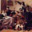

baroque の絵画


In [15]:
loader = ArtBenchDatasetLoader("./artbench", limit_per_class=200)
pairs = loader.load()

print(len(pairs))
display(pairs[0]["image"])
print(pairs[0]["text"])


In [16]:
# MiniCLIPモデルを初期化
text_encoder = TextEncoder(TEXT_MODEL_NAME, EMBED_DIM, DEVICE)
image_encoder = ImageEncoder(EMBED_DIM, DEVICE)
mini_clip = MiniCLIP(text_encoder, image_encoder)

# 学習開始
mini_clip.train(image_text_pairs, epochs=10, batch_size=32)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 69.5MB/s]


Epoch 1/10, Loss: 1.5131
Epoch 2/10, Loss: 1.2465
Epoch 3/10, Loss: 1.0184
Epoch 4/10, Loss: 0.8269
Epoch 5/10, Loss: 0.6682
Epoch 6/10, Loss: 0.5378
Epoch 7/10, Loss: 0.4310
Epoch 8/10, Loss: 0.3439
Epoch 9/10, Loss: 0.2733
Epoch 10/10, Loss: 0.2161
Training completed.


# VectorDB構築＆検索＆可視化

In [28]:
# VectorDB構築
vecdb = SimpleVectorDB()
vecdb.build_from_pairs(text_encoder, image_encoder, pairs)
print(f"VectorDB size: {len(vecdb.items)} items")

VectorDB size: 4000 items


# VectorDBテスト

sim=1.000 | type=text | text=baroque の絵画


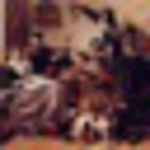

sim=1.000 | type=text | text=baroque の絵画


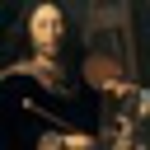

sim=1.000 | type=text | text=baroque の絵画


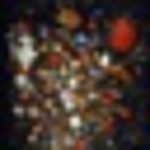

sim=1.000 | type=text | text=baroque の絵画


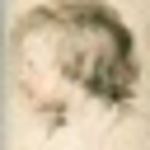

sim=1.000 | type=text | text=baroque の絵画


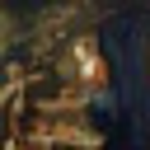

sim=0.577 | text=art_nouveau の絵画


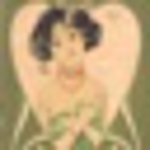

sim=0.558 | text=realism の絵画


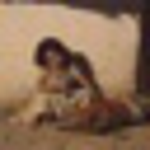

sim=0.549 | text=ukiyo_e の絵画


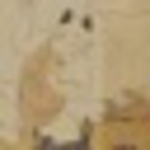

sim=0.522 | text=realism の絵画


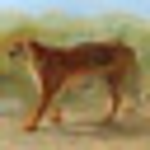

sim=0.522 | text=baroque の絵画


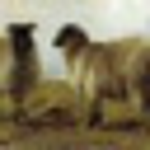

In [33]:
# テキストでクエリ
query_text = "baroque の絵画"
query_vec = text_encoder.encode(query_text).detach().cpu().numpy()[0]

results = vecdb.search(query_vec, top_k=5)

for sim, item in results:
    print(f"sim={sim:.3f} | type={item['type']} | text={item['text']}")
    display(item["image"].resize((150, 150)))


# imageでクエリ
img = image_text_pairs[0]["image"]
img_vec = image_encoder.encode(img).detach().cpu().numpy()[0]

results = vecdb.search(img_vec, top_k=5)

for sim, item in results:
    print(f"sim={sim:.3f} | text={item['text']}")
    display(item["image"].resize((150,150)))

# UMAP 可視化

In [ ]:
embs = np.stack([it["vec"] for it in vecdb.items], axis=0)
labels = [it["type"] for it in vecdb.items]
texts = [it["text"] for it in vecdb.items]

# plot_umap_matplotlib(embs, labels, texts, title="Mini-CLIP: Dog Demo (Matplotlib)")
plot_umap_plotly(embs, labels, texts, title="Mini-CLIP: Dog Demo (Plotly)")

# Export image

In [ ]:
os.makedirs("artifacts", exist_ok=True)

# projector 保存
torch.save(text_encoder.projector.state_dict(), "artifacts/text_projector.pt")
torch.save(image_encoder.projector.state_dict(), "artifacts/image_projector.pt")

# VectorDB 保存
with open("artifacts/vector_db.json", "w", encoding="utf-8") as f:
    json.dump(vecdb.to_jsonable(), f, ensure_ascii=False, indent=2)

print("Saved to ./artifacts/")

#### 日本語表示対応

In [ ]:
# # 日本語フォントをダウンロードする。
# !apt-get -y install fonts-ipafont-gothic
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'IPAGothic'

# import shutil
# import os
# # フォントキャッシュを削除
# font_cache_path = os.path.expanduser("~/.cache/matplotlib")
# if os.path.exists(font_cache_path):
#     shutil.rmtree(font_cache_path)